In [1]:
import algorithm
import dataset_loader
import matplotlib.pyplot as plt
from midi import MIDIUnitSequence
from midi import MIDIUnitSequenceList
from midi import NUM_MIDI_KEYS
import numpy as np

from tqdm import tqdm

In [2]:
ROOT_PATH="../../sabana/dataset/asap-dataset"
# ROOT_PATH = "../dataset/newbie-dataset"

In [3]:
SLICE_DURATION = 5 # sec
EXPANSION_RATE = 2.0
FRAME_PER_SECOND = 20 # Hz
NUM_SAMPLES = 1
QUEUE_SIZE = 8
ONSET_WEIGHT = 10.0
SETTLE_FRAME = 10
COMPENSATION_FRAME = 0

In [4]:
def plot_matrix(name, matrix, head=None, tail=None):
    plt.figure("name", figsize=(16, 3))
    plt.imshow(matrix, cmap="gray", aspect="auto", origin="lower", interpolation="nearest")
    if head:
        plt.plot([head, head], [0, 128])
    if tail:
        plt.plot([tail, tail], [0, 128])
    plt.title(name)
    plt.ylabel("%d Pitches" % matrix.shape[0])
    plt.xlabel("%d Spectrogram Frames" % matrix.shape[1])
    plt.show()

def process_decay(midi_matrix):
    midi_matrix = np.reshape(midi_matrix, [NUM_MIDI_KEYS, -1]).T
    geo_ratio = (0.1)**(1/SETTLE_FRAME)
    for frame_idx in range(len(midi_matrix)):
        for midi_key in range(NUM_MIDI_KEYS):
            if midi_matrix[frame_idx, midi_key] <= 0:
                continue
            elif frame_idx > 0:
                prev_velocity = midi_matrix[frame_idx - 1, midi_key]
                if prev_velocity > 0:
                    velocity = prev_velocity * geo_ratio
                else:
                    velocity = ONSET_WEIGHT
            else:
                velocity = ONSET_WEIGHT
            midi_matrix[frame_idx, midi_key] = velocity

  0%|          | 0/1 [00:00<?, ?it/s]

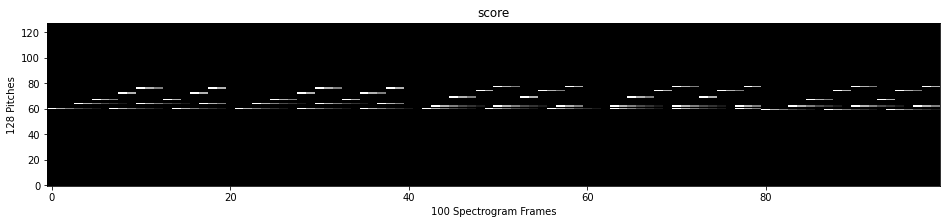

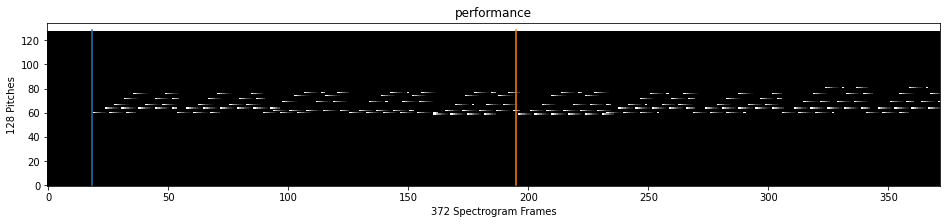

100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


In [5]:
gen = dataset_loader.spawn(dataset_root=ROOT_PATH, slice_duration=SLICE_DURATION, expansion_rate=EXPANSION_RATE, shuffle=True)

prev_perfs = [None] * QUEUE_SIZE
for idx in tqdm(range(NUM_SAMPLES)):
    score, perf, (head, tail) = gen.__next__()

    process_decay(score)
    process_decay(perf)

    plot_matrix("score", score)
    plot_matrix("performance", perf, head, tail)
    
    if isinstance(prev_perfs[0], np.ndarray):
        prev_perf = prev_perfs[0]
        plot_matrix("score", score)
        plot_matrix("previous performance", prev_perf)
        
    prev_perfs.pop(0)
    prev_perfs.append(perf)

In [ ]:
gen = dataset_loader.spawn(dataset_root=ROOT_PATH, slice_duration=SLICE_DURATION, expansion_rate=EXPANSION_RATE, shuffle=True)
for idx in range(NUM_SAMPLES):
    score, perf, (head, tail) = gen.__next__()

    score_sequence = MIDIUnitSequenceList.from_midi_matrix(score, ONSET_WEIGHT, decay_fn).to_significant_unit_sequence(unit_metric)
    perf_sequence = MIDIUnitSequenceList.from_midi_matrix(perf, ONSET_WEIGHT, decay_fn).to_significant_unit_sequence(unit_metric)

    cost, (head_, tail_), D, deltas = algorithm.subsequence_matching(score_sequence, perf_sequence, cost_metric)
    
    plt.figure(figsize=(16, 3))
    plt.title("Score")
    plt.imshow(score, cmap="gray", aspect="auto", origin="lower", interpolation="nearest")
    plt.ylim(0, 127)
    plt.ylabel("Pitch")
    plt.xlabel("Spectrogram Frame")
    plt.show()
    plt.clf()

    plt.figure(figsize=(16, 3))
    plt.title("Performance")
    plt.imshow(perf, cmap="gray", aspect="auto", origin="lower", interpolation="nearest")
    plt.plot([head, head], [0, 128], label="True head")
    plt.plot([tail, tail], [0, 128], label="True tail")
    plt.plot([head_, head_], [0, 128], label="Predicted head")
    plt.plot([tail_, tail_], [0, 128], label="Predicted tail")
    plt.legend()
    plt.ylim(0, 127)
    plt.ylabel("Pitch")
    plt.xlabel("Spectrogram Frame")
    plt.show()
    plt.clf()

    plt.title("Accumulated Cost Matrix")
    plt.imshow(D, cmap="gray", aspect="auto", origin="lower", interpolation="nearest")
    plt.ylabel("Score")
    plt.xlabel("Performance")
    plt.show()
    plt.clf()

    plt.title("Delta functions")
    # deltas = np.reshape(deltas, [1, -1])
    # plt.imshow(deltas, cmap="gray", aspect="auto", origin="lower", interpolation="nearest")
    plt.plot(np.arange(len(deltas)),deltas)
    plt.show()
    plt.clf()